# 2. Q-Learning

## 2.1 Learning from experts

In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv
from Q_learning import eps_policy, eps_policy_self_practice
from tqdm.notebook import tqdm
env = TictactoeEnv()

In [2]:
eps_agents = [0,0.3,0.6,0.9]
eps_rewards = []
for eps_agent in eps_agents:
    print('Started learning with eps_agent={:.1f}'.format(eps_agent))
    _, rewards_250 = eps_policy(env, Q_table=dict(), eps_agent=eps_agent)
    eps_rewards.append(rewards_250)

Started learning with eps_agent=0.0
Learning finished after 47.16s
Played a total of 20000 games
Started learning with eps_agent=0.3
Learning finished after 45.67s
Played a total of 20000 games
Started learning with eps_agent=0.6
Learning finished after 44.51s
Played a total of 20000 games
Started learning with eps_agent=0.9
Learning finished after 40.86s
Played a total of 20000 games


#### Question 1: Plot the average reward after every 250 games with different agent eps in [0, 1)

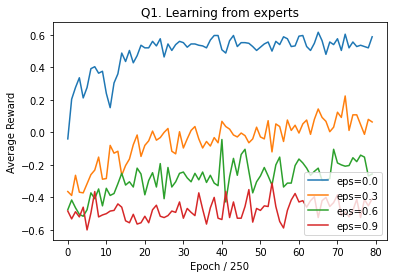

In [28]:
for eps_agent, eps_reward in zip(eps_agents, eps_rewards):
    plt.plot(eps_reward, label='eps={:.1f}'.format(eps_agent))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q1. Learning from experts')
plt.legend(loc='lower right')
# txt="Average rewards after every 250 games with different values for the exploration rate of the agent"
# plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./plots/q1.png')
plt.show()


### 2.1.1 Decreasing exploration

In [14]:
expl_games = [1, 100, 10000, 40000]
expl_rewards = []
for nb_expl_games in expl_games:
    print('Started learning with expl_games={}'.format(nb_expl_games))
    _, rewards_expl_250 = eps_policy(env, Q_table=dict(), eps_agent=-1, expl_games=nb_expl_games)
    expl_rewards.append(rewards_expl_250)

Started learning with expl_games=1
Learning finished after 44.09s
Played a total of 20000 games
Started learning with expl_games=100
Learning finished after 46.18s
Played a total of 20000 games
Started learning with expl_games=10000
Learning finished after 43.43s
Played a total of 20000 games
Started learning with expl_games=40000
Learning finished after 42.64s
Played a total of 20000 games


#### Question 2: Plot the average reward after every 250 games with different numbers of exploratory games

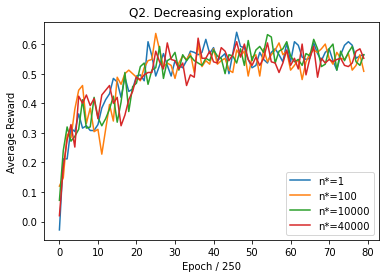

In [15]:
for expl_game, expl_reward in zip(expl_games, expl_rewards):
    plt.plot(expl_reward, label='n*={}'.format(expl_game))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q2. Decreasing exploration')
# plt.title('Average rewards after every 250 games with different values of n*')
plt.legend()
plt.savefig('./plots/q2.png')
plt.show()

#### Question 3: Compute 'test' M_opt and M_rand after every 250 games 

In [16]:
expl_games = [1, 100, 10000, 40000]
eps_vs_opt_rewards = []
eps_vs_rnd_rewards = []
for nb_expl_games in expl_games:
    print('Started learning with expl_games={}'.format(nb_expl_games))
    _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), eps_agent=-1, expl_games=nb_expl_games, test_opt_vs_rnd=True)
    eps_vs_opt_rewards.append(M_opts)
    eps_vs_rnd_rewards.append(M_rnds)

Started learning with expl_games=1
Learning finished after 226.20s
Played a total of 20000 games
Started learning with expl_games=100
Learning finished after 225.80s
Played a total of 20000 games
Started learning with expl_games=10000
Learning finished after 228.24s
Played a total of 20000 games
Started learning with expl_games=40000
Learning finished after 226.36s
Played a total of 20000 games


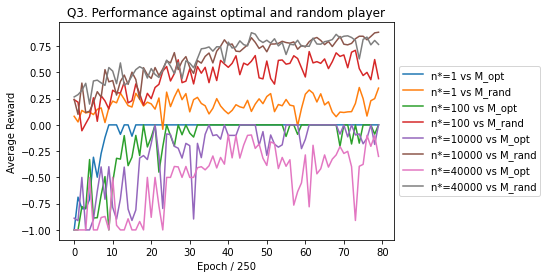

In [44]:
for idx, expl_game in enumerate(expl_games):
    plt.plot(eps_vs_opt_rewards[idx], label='n*={} vs M_opt'.format(expl_game))
    plt.plot(eps_vs_rnd_rewards[idx], label='n*={} vs M_rand'.format(expl_game))
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q3. Performance against optimal and random player')
plt.savefig('./plots/q3.png', bbox_inches='tight')
plt.show()

### 2.1.2 Good expoerts and bad experts

In [29]:
best_expl_games = 10000

#### Question 4: Test best n* against optimal with different exploration level

In [30]:
eps_opts = [0, 0.3, 0.6, 0.9]
eps_rewards = []
eps_vs_opt_rewards = []
eps_vs_rnd_rewards = []
for eps_opt in eps_opts:
    print('Started learning with eps_opt={:.1f}'.format(eps_opt))
    _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), eps_opt=eps_opt, decay_eps=True, expl_games=best_expl_games, test_opt_vs_rnd=True)
    eps_vs_opt_rewards.append(M_opts)
    eps_vs_rnd_rewards.append(M_rnds)

Started learning with eps_opt=0.0
Learning finished after 287.63s
Played a total of 20000 games
Started learning with eps_opt=0.3
Learning finished after 243.45s
Played a total of 20000 games
Started learning with eps_opt=0.6
Learning finished after 225.06s
Played a total of 20000 games
Started learning with eps_opt=0.9
Learning finished after 200.10s
Played a total of 20000 games


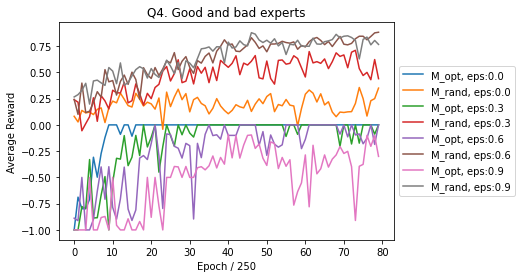

In [43]:
for idx, eps_opt in enumerate(eps_opts):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt, eps:{:.1f}'.format(eps_opt))
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand, eps:{:.1f}'.format(eps_opt))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q4. Good and bad experts')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('./plots/q4.png', bbox_inches='tight')
plt.show()

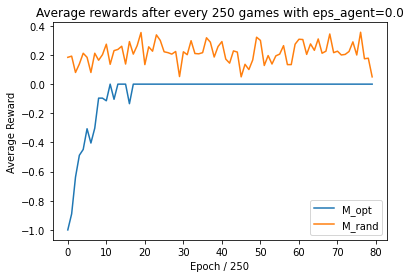

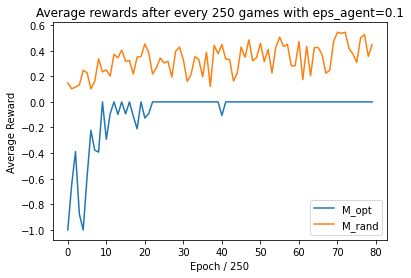

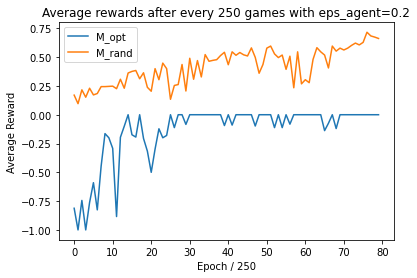

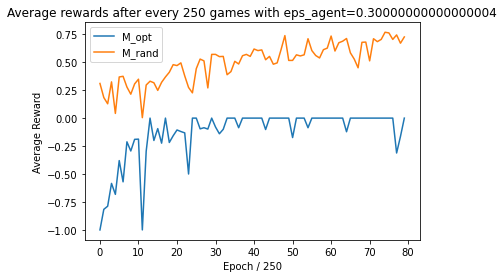

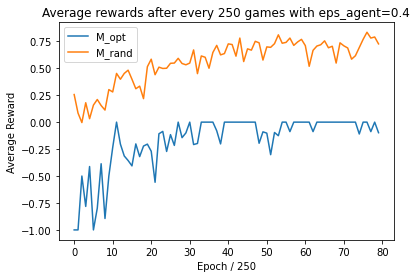

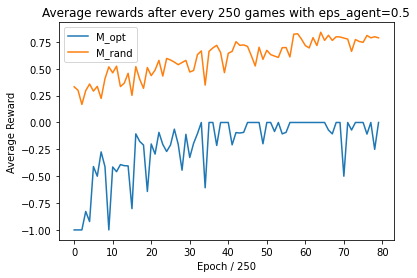

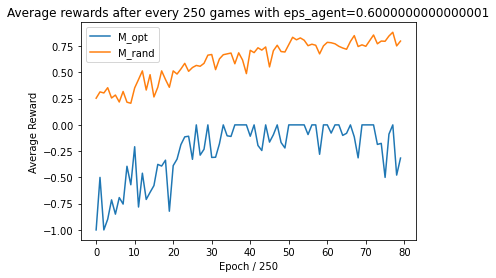

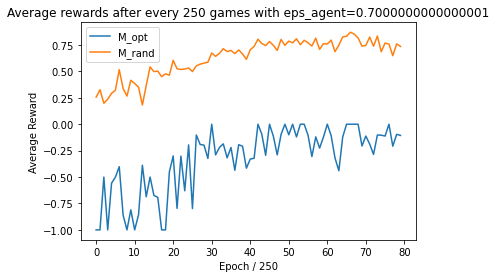

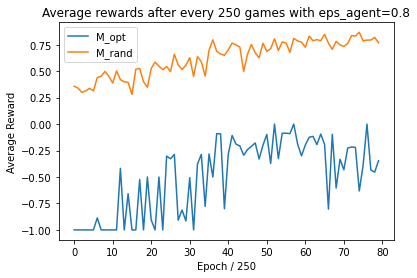

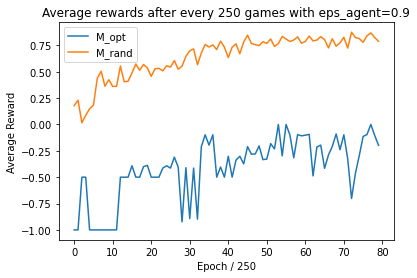

In [14]:
for idx, eps_opt in enumerate(eps_opts):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt')
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand')
    plt.legend()
    plt.xlabel('Epoch / 250')
    plt.ylabel('Average Reward')
    plt.title('Average rewards after every 250 games with eps_opt={}'.format(eps_opt))
    plt.show()

#### Question 5: What are the highest values of M_opt and M_rand achieved after 20 000 games ?

In [15]:
print('Best M_opt after 20000 games: {:.3f}'.format(np.max(eps_vs_opt_rewards)))
print('Best M_rnd after 20000 games: {:.3f}'.format(np.max(eps_vs_rnd_rewards)))

Best M_opt after 20000 games: 0.000
Best M_rnd after 20000 games: 0.882


The highest $\begin{aligned}M_{opt}\end{aligned}$ is equal to 0. This is normal and to be awaited since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in a draw.

The highest $\begin{aligned}M_{rand}\end{aligned}$ is equal to 0.882. This value is pretty high but is not out of the ordinary since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in either a win for the agent or a draw.



#### Question 6: Agent 1 learns by playing against Opt(0) and finds optimal Q1(s,a). Agent 2 learns by playing against Opt(1) and finds optimal Q2(s,a). Do Q1(s, a) and Q2(s, a) have the same values?

The answer is no. Since Agent 1 plays against an optimal player who always chooses the best action, the game always ends in either a draw or a loose for Agent 1. This means that all the Q-values of Agent 1 will be smaller or equal 0 since the only possibility to obtain a positive reward is by winning a game. On the other hand, Agent 2 will win most of its games and never loose once he has learned the optimal Q-values. Thus he will have Q-values that are greater then 0.

### Learning by self-practive

#### Question 7:  Plot the average reward for the self-practive after every 250 games with different agent eps in [0, 1) 

In [3]:
eps_agents = np.arange(0, 1, 0.1)
eps_vs_opt_rewards = []
eps_vs_rnd_rewards = []
for eps_agent in tqdm(eps_agents):
    print('Started learning with eps_opt={:.1f}'.format(eps_agent))
    _, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), eps_agents=eps_agent, decay_eps=False)
    eps_vs_opt_rewards.append(M_opts)
    eps_vs_rnd_rewards.append(M_rnds)

  0%|          | 0/10 [00:00<?, ?it/s]

Started learning with eps_opt=0.0


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 234.33s
Played a total of 20000 games
Started learning with eps_opt=0.1


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 305.81s
Played a total of 20000 games
Started learning with eps_opt=0.2


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 261.23s
Played a total of 20000 games
Started learning with eps_opt=0.3


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 220.84s
Played a total of 20000 games
Started learning with eps_opt=0.4


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 223.16s
Played a total of 20000 games
Started learning with eps_opt=0.5


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 222.10s
Played a total of 20000 games
Started learning with eps_opt=0.6


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 210.91s
Played a total of 20000 games
Started learning with eps_opt=0.7


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 206.59s
Played a total of 20000 games
Started learning with eps_opt=0.8


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 203.56s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 195.13s
Played a total of 20000 games


IndexError: list index out of range

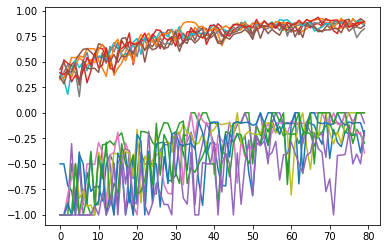

In [8]:
for idx, eps_agent in enumerate(eps_agents):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt_eps_{:.1f}'.format(eps_agent))
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand_eps_{:.1f}'.format(eps_agent))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Average rewards after every 250 games with different values for the exploration rate')
plt.legend()
plt.savefig('./plots/q7.png')
plt.show()

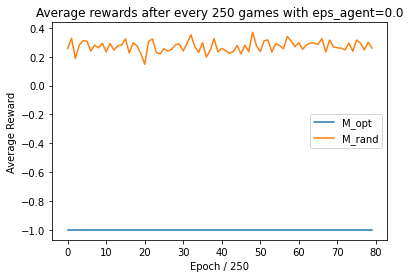

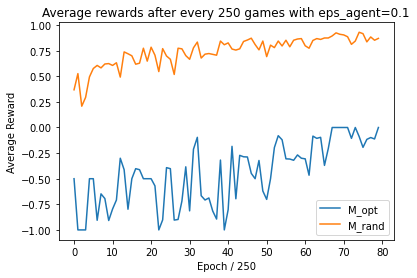

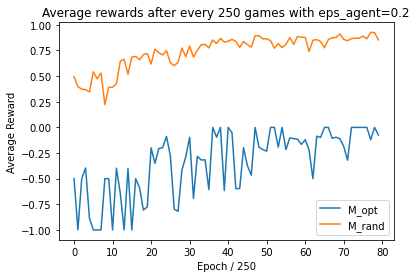

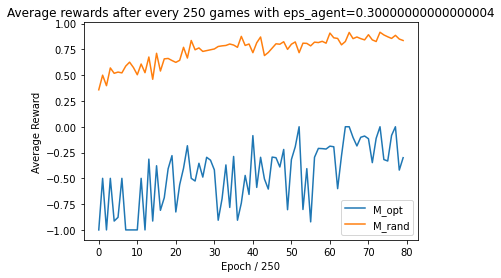

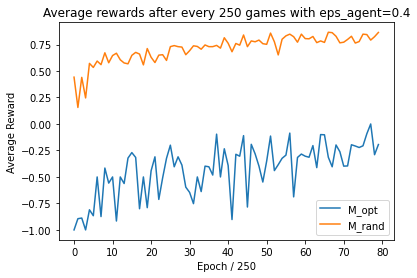

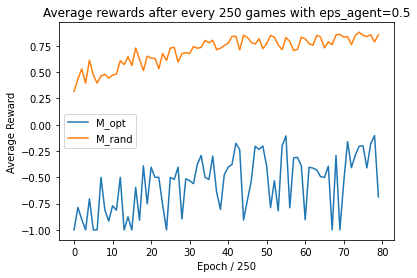

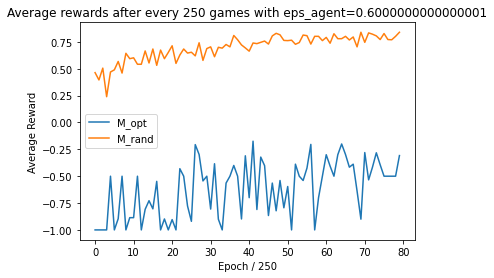

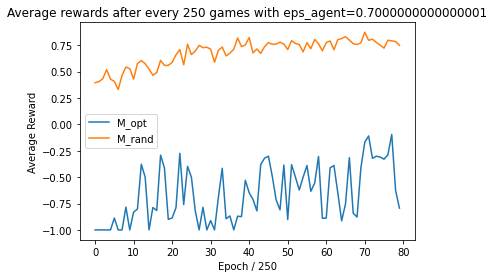

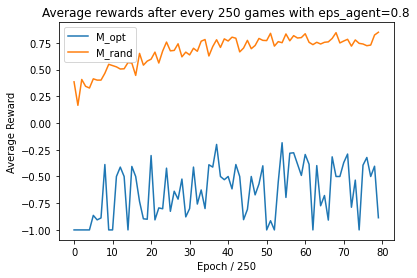

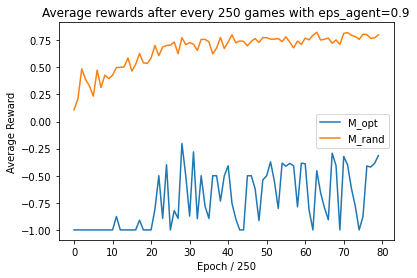

In [5]:
for idx, eps_agent in enumerate(eps_agents):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt')
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand')
    plt.legend()
    plt.xlabel('Epoch / 250')
    plt.ylabel('Average Reward')
    plt.title('Average rewards after every 250 games with eps_agent={}'.format(eps_agent))
    plt.show()

#### Question 8: Plot the average reward after every 250 games with different agent eps in [0, 1)

In [6]:
expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
eps_vs_opt_rewards = []
eps_vs_rnd_rewards = []
for expl_game in tqdm(expl_games):
    print('Started learning with eps_opt={:.1f}'.format(eps_agent))
    _, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), decay_eps=True, expl_games=expl_game)
    eps_vs_opt_rewards.append(M_opts)
    eps_vs_rnd_rewards.append(M_rnds)

  0%|          | 0/8 [00:00<?, ?it/s]

Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 223.69s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 225.56s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 224.15s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 222.68s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 221.91s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 216.70s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 213.02s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 201.97s
Played a total of 20000 games


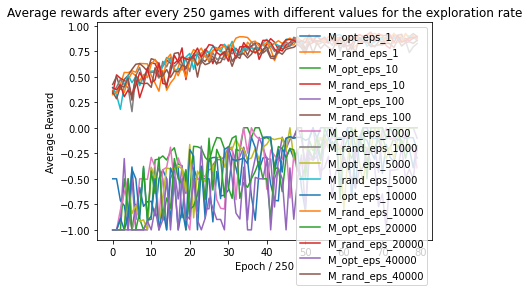

In [12]:
for idx, expl_game in enumerate(expl_games):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt_eps_{}'.format(expl_game))
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand_eps_{}'.format(expl_game))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.legend()
plt.title('Average rewards after every 250 games with different values for the exploration rate')
plt.savefig('./plots/q8.png')
plt.show()

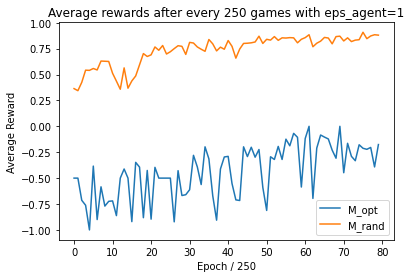

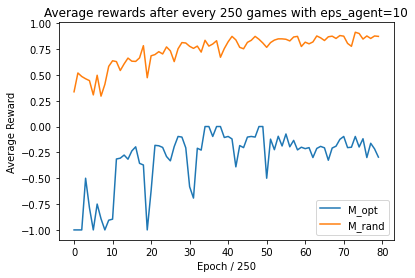

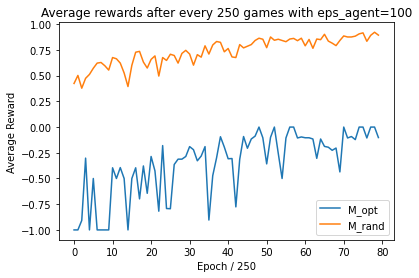

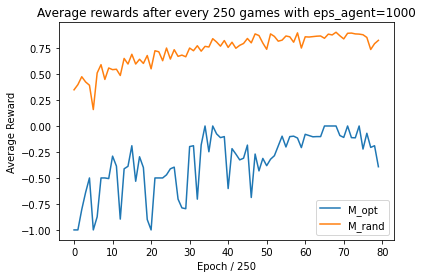

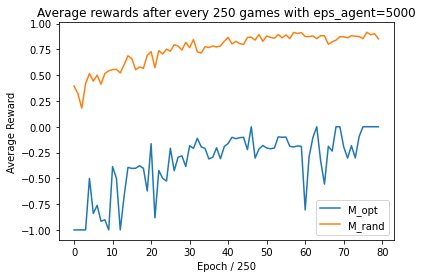

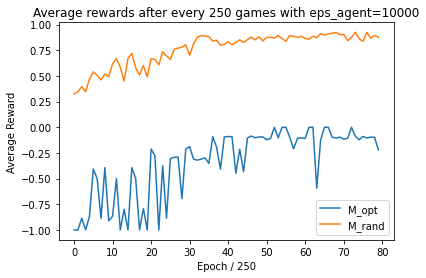

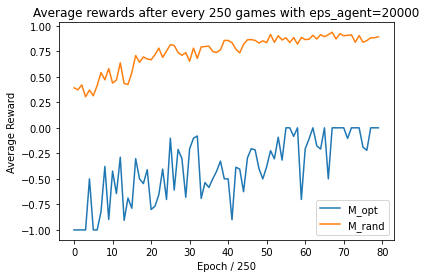

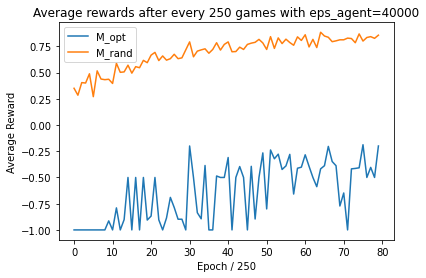

In [13]:
for idx, expl_game in enumerate(expl_games):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt')
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand')
    plt.legend()
    plt.xlabel('Epoch / 250')
    plt.ylabel('Average Reward')
    plt.title('Average rewards after every 250 games with n*={}'.format(expl_game))
    plt.show()

#### Question 9: What are the highest values for Mopt and Mrand achieved after 20 000 games?

In [17]:
best_M_opt = max(max(eps_vs_opt_rewards))
best_M_rand = max(max(eps_vs_rnd_rewards))
print('Best M_opt: {}'.format(best_M_opt))
print('Best M_rand: {:.4f}'.format(best_M_rand))

Best M_opt: 0.0
Best M_rand: 0.9220


#### Question 10: 

In [ ]:
q, m_opt, m_rnd = eps_policy_self_practice(env, Q_table=dict(), nb_epochs=20000, eps_agent=0.2)
plt.plot(m_opt, label='M_opt')
plt.plot(m_rnd, label='M_rand')
plt.legend()
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Average rewards after every 250 games')
plt.show()